# GMSNBurr Distribution: Usage Examples

This notebook demonstrates the core features of the `GMSNBurr` custom distribution. We will cover:
1.  Installation and importing.
2.  Direct calculations (PDF, CDF, random sampling).
3.  Integration with a **PyMC** model.
4.  Usage as a custom family in **Bambi**.

## 1. Installation & Setup

First, install the package directly from the GitHub repository.

```bash
pip install git+https://github.com/ezrazia/GMSNBurr-pada-PyMC-dan-Bambi.git
```

Once installed, we can import the library. Don't forget to install and import necessary libraries.

In [18]:
# Import the custom distribution
from gmsnburr import GMSNBurr

# Set some default parameters for the examples
mu, sigma, alpha1, alpha2 = 3, 1, 0.1, 4

## 2. Direct Calculations

The `GMSNBurr` class provides static methods for direct calculations, which can handle both single scalar values and NumPy arrays.

### Probability Density Function (PDF)

Calculate the PDF for a single point (scalar input) and for multiple points (vector input).

In [19]:
# Scalar input
pdf_single = GMSNBurr.pdf(x=1.5, mu=mu, sigma=sigma, alpha1=alpha1, alpha2=alpha2)
print(f"PDF for a single point: {pdf_single:.4f}")

# Vector input
x_values = np.array([-1.0, 0.0, 1.5])
pdf_multi = GMSNBurr.pdf(x=x_values, mu=mu, sigma=sigma, alpha1=alpha1, alpha2=alpha2)
print(f"PDF for multiple points: {pdf_multi}")

PDF for a single point: 0.1979
PDF for multiple points: [0.05196192 0.0887122  0.19788645]


### Cumulative Distribution Function (CDF)

Similarly, calculate the CDF for single or multiple points.

In [20]:
# Vector input
cdf_multi = GMSNBurr.cdf(x=x_values, mu=mu, sigma=sigma, alpha1=alpha1, alpha2=alpha2)
print(f"CDF for multiple points: {cdf_multi}")

CDF for multiple points: [0.09714573 0.16585245 0.36997113]


### Random Sampling

Generate random samples from the distribution.

In [24]:
# Generate 5 random samples
random_samples = GMSNBurr.random(size=1000, mu=mu, sigma=sigma, alpha1=alpha1, alpha2=alpha2)
print(f"Five random samples: {random_samples[:5]}")

Five random samples: [  1.01627606 -22.7326715   18.10532851 -74.14546916   2.38775526]


## 3. Advanced Integration

The primary purpose of this package is to integrate with PyMC and Bambi.

### PyMC Model

Use `GMSNBurr` as a custom likelihood in a PyMC model.

In [ ]:
import pymc as pm

# This dictionary contains arguments for the PyMC sampler.
# Adjust these sampler parameters according to your research needs.
sampler_kwargs = { 
    "chains": 4,
    "cores": 4,
    "return_inferencedata": True,
    "random_seed": 42,
    "tune": 1000,
    "draws": 1000,
    "nuts_sampler_kwargs":{"target_accept": 0.9}
}

with pm.Model() as modelSamp:
  # This is a prior. Use a prior that is appropriate for your domain knowledge.
  mu = pm.Normal("mu", mu=3, sigma=1)
  sigma = pm.HalfCauchy("sigma", beta=2)
  alpha1 = pm.LogNormal("alpha1", mu=-2, sigma=0.5)
  alpha2 = pm.LogNormal("alpha2", mu=1.3, sigma=0.5)
  
  # This is the likelihood. 
  y = GMSNBurr.main("GMSNBurrDist", mu=mu,  # The variables `mu`, `sigma`, `alpha1`, and `alpha2` are the priors used to model the data.
                    sigma=sigma, 
                    alpha1=alpha1, 
                    alpha2=alpha2, 
                    observed=random_samples) # The `observed` argument should use your data.
  
  # This computes the posterior using the `sampler_kwargs` you defined earlier.
  traceSamp = pm.sample(**sampler_kwargs)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, alpha1, alpha2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


In [ ]:
import arviz as az

# Generate a statistical summary of the posterior distributions.
# The first argument is the InferenceData object from the pm.sample() call.
az.summary(traceSamp)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,2.828,0.126,2.595,3.057,0.003,0.002,2009.0,2049.0,1.0
sigma,0.994,0.091,0.826,1.164,0.002,0.002,2410.0,2608.0,1.0
alpha1,0.121,0.039,0.056,0.195,0.001,0.001,2175.0,2451.0,1.0
alpha2,4.277,2.242,1.101,8.486,0.045,0.056,2693.0,2401.0,1.0


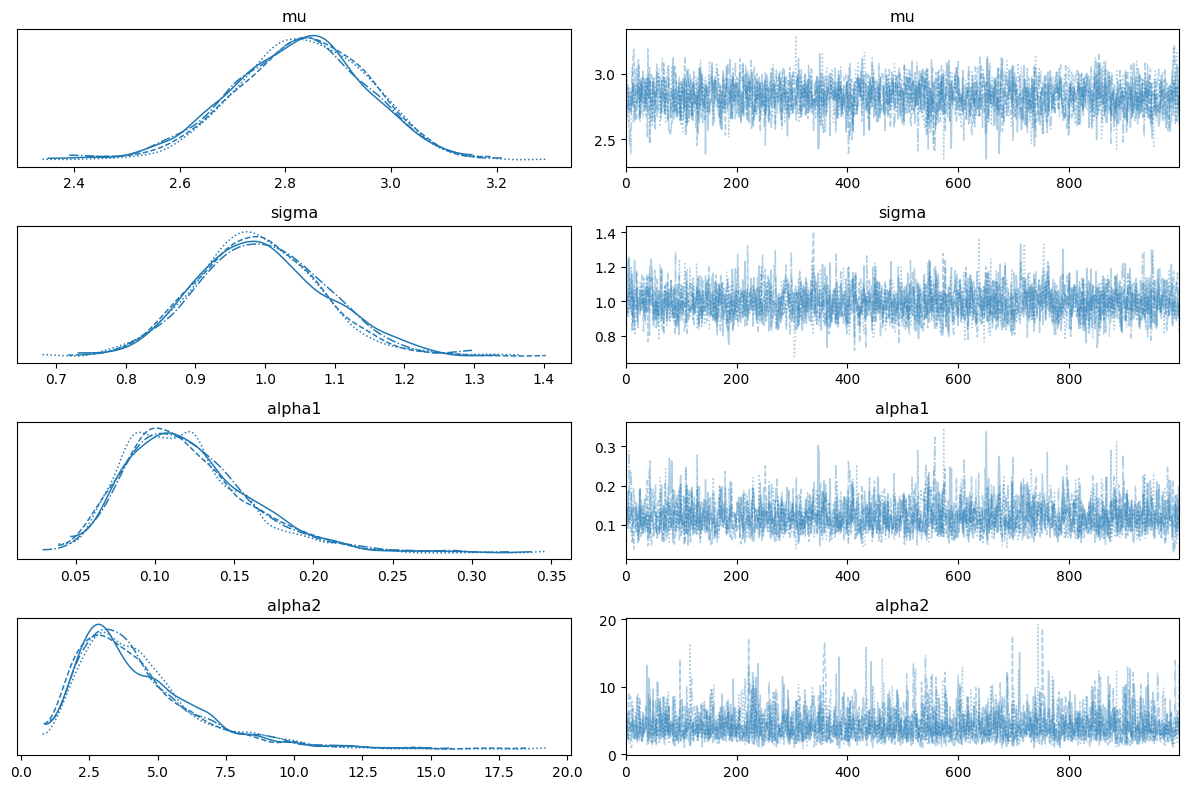

In [ ]:
import matplotlib.pyplot as plt

# Create trace plots for MCMC diagnostics and posterior visualization.
# This typically generates two plots per parameter:
# 1. A Kernel Density Estimate (KDE) of the posterior distribution on the left.
# 2. The trace of the samples across all chains on the right, which helps check for convergence.
az.plot_trace(traceSamp)

plt.tight_layout()
plt.show()

### Bambi Model

Use `gmsnburr` as a custom family in a Bambi model.

In [ ]:
import numpy as np
import pandas as pd
np.random.seed(42)

# --- 1. Generate Predictor Variables ---
# Generate two independent predictor variables (features) from a standard normal distribution.
x1 = np.random.normal(0, 1, 1000)
x2 = np.random.normal(0, 1, 1000)

# --- 2. Define the True Model Parameters ---
# Define the true, underlying coefficients for the linear part of the model.
b0_true = 0.48 # True intercept
b1_true = 0.74 # True slope for x1
b2_true = 0.05 # True slope for x2

# --- 3. Create the Outcome Variable (y) ---
# Calculate the deterministic component of the outcome (the "signal").
ycap = b0_true + b1_true * x1 + b2_true * x2

# Generate the stochastic error term (the "noise") from the custom GMSNBurr distribution.
# This assumes the GMSNBurr class is available and imported.
eps = GMSNBurr.random(1000,3,1,0.1,4)

# Create the final observed outcome by adding the signal and the noise.
y = ycap + eps

# --- 4. Assemble the DataFrame ---
# Combine all the simulated variables into a single pandas DataFrame for analysis.
data = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})

In [ ]:
import bambi as bmb

# Specify the Bambi model using a formula string.
# The formula "y ~ x1 + x2" defines the relationship between the response and predictors.
# The `family` argument is crucial; it's set to our custom GMSNBurr distribution.
modelBambi = bmb.Model("y ~ x1 + x2", data, family=GMSNBurr.family)

# Fit the model to the data by running the MCMC sampler (PyMC's NUTS sampler).
# The previously defined `sampler_kwargs` dictionary is unpacked to pass all sampler settings.
# This returns an ArviZ InferenceData object containing the results.
paramsBambi = modelBambi.fit(**sampler_kwargs)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha2, alpha1, sigma, Intercept, x1, x2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


In [11]:
az.summary(paramsBambi)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha2,3.585,1.520,1.411,6.152,0.029,0.043,2645.0,2526.0,1.0
alpha1,0.127,0.021,0.089,0.166,0.001,0.000,1515.0,1747.0,1.0
sigma,0.958,0.032,0.900,1.018,0.001,0.000,2359.0,2669.0,1.0
Intercept,3.417,0.051,3.322,3.515,0.001,0.001,1722.0,1941.0,1.0
x1,0.720,0.022,0.678,0.762,0.000,0.000,3296.0,2590.0,1.0
x2,0.069,0.023,0.025,0.113,0.000,0.000,4080.0,3108.0,1.0


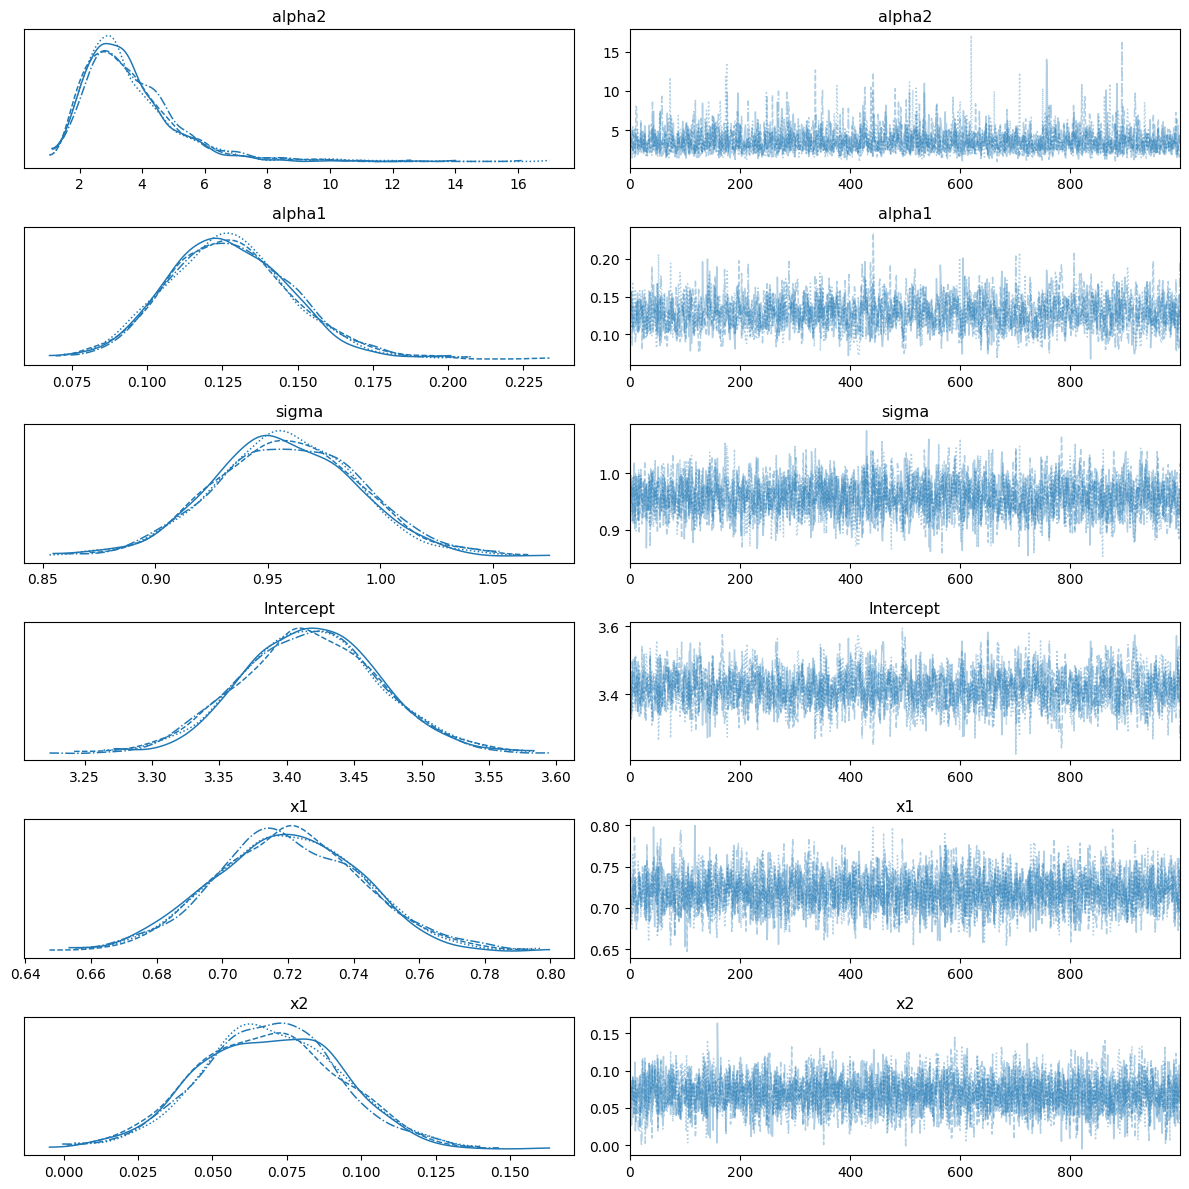

In [12]:
az.plot_trace(paramsBambi)
plt.tight_layout()
plt.show()